# Loading in the data

In [7]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline

In [8]:
df_train = pd.read_csv('Train.csv')
df = pd.read_csv('Test.csv')
df_train.head()

,ward,total_households,total_individuals,target,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,...,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,ADM4_PCODE,lat,lon,NL
0,41601001: Ward 1,1674.45058,5888.20750,16.773757,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,...,0.002848,0.007537,0.000000,0.012928,0,0,ZA4161001,-29.682270,24.734743,0.292039
1,41601002: Ward 2,1736.99230,6735.33812,21.496661,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,...,0.014566,0.057127,0.019092,0.004131,0,0,ZA4161002,-29.119311,24.757737,3.207775
2,41601003: Ward 3,2403.57591,7273.04995,10.931425,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,...,0.057560,0.010358,0.001421,0.040881,0,0,ZA4161003,-29.142276,25.094093,0.000000
3,41601004: Ward 4,1740.78737,5734.49046,23.119257,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,...,0.000000,0.000669,0.000000,0.005011,0,0,ZA4161004,-29.372052,24.942867,2.038778
4,41601005: Ward 5,1730.51451,6657.23835,13.652252,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,...,0.004859,0.001290,0.000673,0.017629,0,0,ZA4161005,-29.409381,25.290165,0.000000


# Modeling 

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
dff = df_train.drop(['ADM4_PCODE', 'ward'], axis = 1)
df_test = df.drop(['ADM4_PCODE', 'ward'], axis = 1)

In [11]:
y = dff['target']
df_train = dff.drop('target', axis = 1)

In [12]:
X_train, X_test, y_train, y_test = train_test_split(df_train, y, test_size=0.3)

In [13]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error

In [14]:
#fitting a model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 500)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

/home/aims/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [15]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 3.393274


### Saving Submission # 1

In [16]:
df['preds'] = xg_reg.predict(df_test)
df[['ward', 'preds']].to_csv('predictions.csv', index=False)
df[['ward', 'preds']]

,ward,preds
0,21001001: Ward 1,18.449717
1,21001002: Ward 2,13.790759
2,21001003: Ward 3,21.268026
3,21001004: Ward 4,19.189753
4,21001005: Ward 5,20.476284
...,...,...
1008,19100107: Ward 107,6.548968
1009,19100108: Ward 108,24.699858
1010,19100109: Ward 109,20.807917
1011,19100110: Ward 110,19.239944


# Linear Regression modeling and Gradient Boosting

In [17]:
from sklearn.linear_model import Lasso
from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, TransformerMixin, RegressorMixin, clone


In [18]:
#validation function
n_folds = 5

def RMSLE_cv(model):
    kf = KFold(n_folds, shuffle=True, random_state=42).get_n_splits(X_train.values)
    rmse= np.sqrt(-cross_val_score(model, X_train.values, y_train, scoring="neg_mean_squared_error",
cv = kf))
    return(rmse)

In [27]:
#lasso
lasso = make_pipeline(RobustScaler(), Lasso(alpha = 0.005, random_state = 1))

#Gradient Boosting Regression
GBoost = GradientBoostingRegressor(loss='huber', learning_rate=0.005, n_estimators=5000,
                                   min_samples_split=2, min_samples_leaf=5,max_depth=4,
                                   random_state=5,max_features='sqrt')

In [28]:
#Lasso
score = RMSLE_cv(lasso)
print ("\n Lasso score: {:.4f} ({:.4f})\n".format(score.mean(),score.std()))

#Gradient Boosting Regression
score = RMSLE_cv(GBoost)
print ("\n GBoost score: {:.4f} ({:.4f})\n".format(score.mean(),score.std()))


 Lasso score: 3.9075 (0.1679)


 GBoost score: 3.3981 (0.1043)



# Data Exploration and Feature Engineering

In [11]:
df_train.head()

,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,...,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,lat,lon,NL
0,1674.45058,5888.20750,0.933841,0.000846,0.005490,0.000676,0.000000,0.001372,0.005750,0.031466,...,0.019968,0.002848,0.007537,0.000000,0.012928,0,0,-29.682270,24.734743,0.292039
1,1736.99230,6735.33812,0.696940,0.001253,0.004402,0.000000,0.002301,0.001323,0.007575,0.123547,...,0.018946,0.014566,0.057127,0.019092,0.004131,0,0,-29.119311,24.757737,3.207775
2,2403.57591,7273.04995,0.810545,0.004517,0.008891,0.003986,0.007735,0.000956,0.006686,0.022632,...,0.083010,0.057560,0.010358,0.001421,0.040881,0,0,-29.142276,25.094093,0.000000
3,1740.78737,5734.49046,0.659914,0.000000,0.006129,0.000000,0.000813,0.037245,0.005255,0.068909,...,0.002689,0.000000,0.000669,0.000000,0.005011,0,0,-29.372052,24.942867,2.038778
4,1730.51451,6657.23835,0.950575,0.000655,0.001473,0.000598,0.006999,0.000818,0.004985,0.009150,...,0.009699,0.004859,0.001290,0.000673,0.017629,0,0,-29.409381,25.290165,0.000000


In [12]:
df_train.describe()

,total_households,total_individuals,dw_00,dw_01,dw_02,dw_03,dw_04,dw_05,dw_06,dw_07,...,pw_02,pw_03,pw_04,pw_05,pw_06,pw_07,pw_08,lat,lon,NL
count,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,...,2822.000000,2822.000000,2822.000000,2822.000000,2822.000000,2822.0,2822.0,2822.000000,2822.000000,2822.000000
mean,3665.281214,12869.130053,0.712196,0.092616,0.032043,0.006057,0.008665,0.006289,0.022375,0.039296,...,0.127555,0.041589,0.019655,0.011008,0.110818,0.0,0.0,-26.880740,28.666515,17.437560
std,3266.364522,9696.690518,0.214035,0.182852,0.080253,0.019374,0.030697,0.024606,0.037127,0.057889,...,0.156400,0.057331,0.032926,0.023672,0.185401,0.0,0.0,2.021279,2.373809,18.958621
min,1.000000,402.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-32.490089,16.760022,0.000000
25%,1778.858235,7071.205695,0.594212,0.002895,0.002407,0.000000,0.000000,0.000000,0.002716,0.004716,...,0.008673,0.002099,0.000715,0.000159,0.005217,0.0,0.0,-28.569019,27.707932,3.033397
50%,2398.249935,9366.989680,0.766841,0.010425,0.005762,0.000807,0.000607,0.000865,0.008639,0.016295,...,0.069065,0.016496,0.005164,0.001459,0.025165,0.0,0.0,-26.549866,28.959679,9.205572
75%,3987.080563,14241.233015,0.881708,0.068209,0.027913,0.002538,0.002225,0.003027,0.025218,0.048730,...,0.183384,0.058626,0.025055,0.009432,0.116638,0.0,0.0,-25.572130,30.441505,26.890531
max,39684.942130,91716.746370,0.994962,0.931490,0.951806,0.264239,0.392085,0.435912,0.412936,0.455815,...,1.000000,0.327393,0.306787,0.228261,0.961523,0.0,0.0,-22.331267,32.858249,63.000000


In [13]:
dff[dff.columns[1:]].corr()['target'][:]

total_individuals   -0.293827
target               1.000000
dw_00                0.018461
dw_01                0.458206
dw_02               -0.232727
dw_03               -0.338137
dw_04               -0.385533
dw_05               -0.146357
dw_06               -0.248573
dw_07               -0.177763
dw_08               -0.186627
dw_09               -0.235331
dw_10               -0.128540
dw_11               -0.109490
dw_12                     NaN
dw_13                     NaN
psa_00               0.782472
psa_01              -0.707506
psa_02              -0.097613
psa_03              -0.301572
psa_04               0.203999
stv_00              -0.664181
stv_01               0.664181
car_00              -0.702831
car_01               0.702831
lln_00              -0.637835
lln_01               0.637835
lan_00              -0.507942
lan_01              -0.438704
lan_02              -0.020163
lan_03              -0.142685
lan_04               0.232266
lan_05               0.275263
lan_06    

In [14]:
new_dff = dff.drop(['dw_12', 'dw_13', 'lan_13', 'pw_07', 'pw_08'], axis = 1)

In [15]:
corr = new_dff.corr()

#correlation with the output variable
cor_target = abs(corr['target'])

#Selecting highly correlated features
relevant_features = cor_target[cor_target>0.4]
relevant_features

target    1.000000
dw_01     0.458206
psa_00    0.782472
psa_01    0.707506
stv_00    0.664181
stv_01    0.664181
car_00    0.702831
car_01    0.702831
lln_00    0.637835
lln_01    0.637835
lan_00    0.507942
lan_01    0.438704
pg_00     0.613346
pg_03     0.583908
pw_00     0.754536
pw_02     0.442441
pw_03     0.440941
pw_06     0.470676
NL        0.514398
Name: target, dtype: float64

In [21]:
X= dff[['dw_01', "psa_00","psa_01","stv_00","stv_01","car_00",
      "car_01","lln_00","lln_01","lan_00","lan_01", "pg_00","pg_03","pw_00","pw_02", "pw_03", "pw_06", "NL"]]

In [22]:
X.shape

(2822, 18)

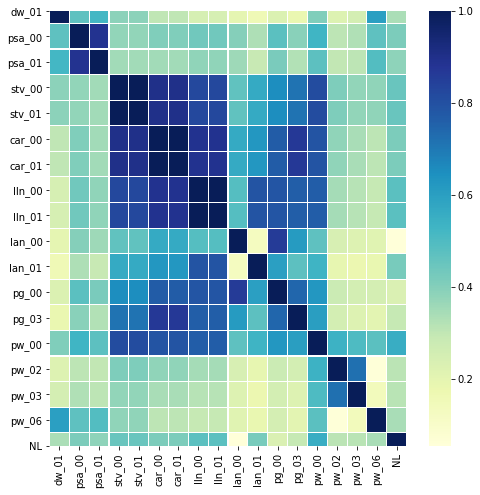

In [23]:
#checking correlation with each other

corr_matrix= X.corr().abs()

f, ax = plt.subplots(figsize =(8, 8))
sns.heatmap(corr_matrix, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

In [24]:
# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]

In [25]:
# Drop features 
X = X.drop(X[to_drop], axis=1)

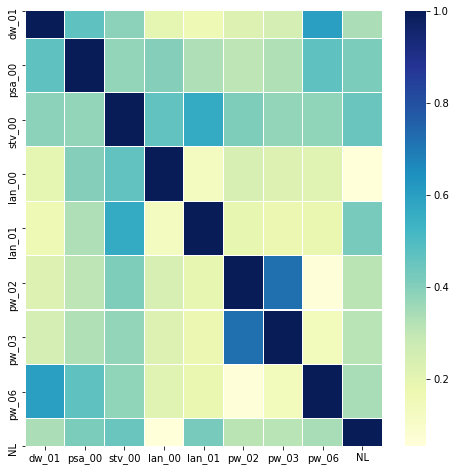

In [26]:
corr_matrix= X.corr().abs()
f, ax = plt.subplots(figsize =(8, 8))
sns.heatmap(corr_matrix, ax = ax, cmap ="YlGnBu", linewidths = 0.1) 

# Modeling

In [27]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

In [28]:
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', n_estimators = 500)
xg_reg.fit(X_train,y_train)
preds = xg_reg.predict(X_test)

/home/aims/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [29]:
rmse = np.sqrt(mean_squared_error(y_test, preds))
print("RMSE: %f" % (rmse))

RMSE: 4.267070
